In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = False

In [4]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [5]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [6]:
epoch = 50

In [7]:
root = 'src/data/dyn_pid_controller/explo'

In [8]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.13217775821685793, 0.0007221597194671631, 0.0008730570785701275]}
{'weights': [0.13217775821685793, 0.0007221597194671631, 0.0008730570785701275]}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.06043556, -0.03838797], dtype=float32), array([-0.01709729, -0.06570367], dtype=float32), array([-4.6245303e-04,  4.7127472e-05], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


-0.0004127848769296962


<IPython.core.display.Javascript object>


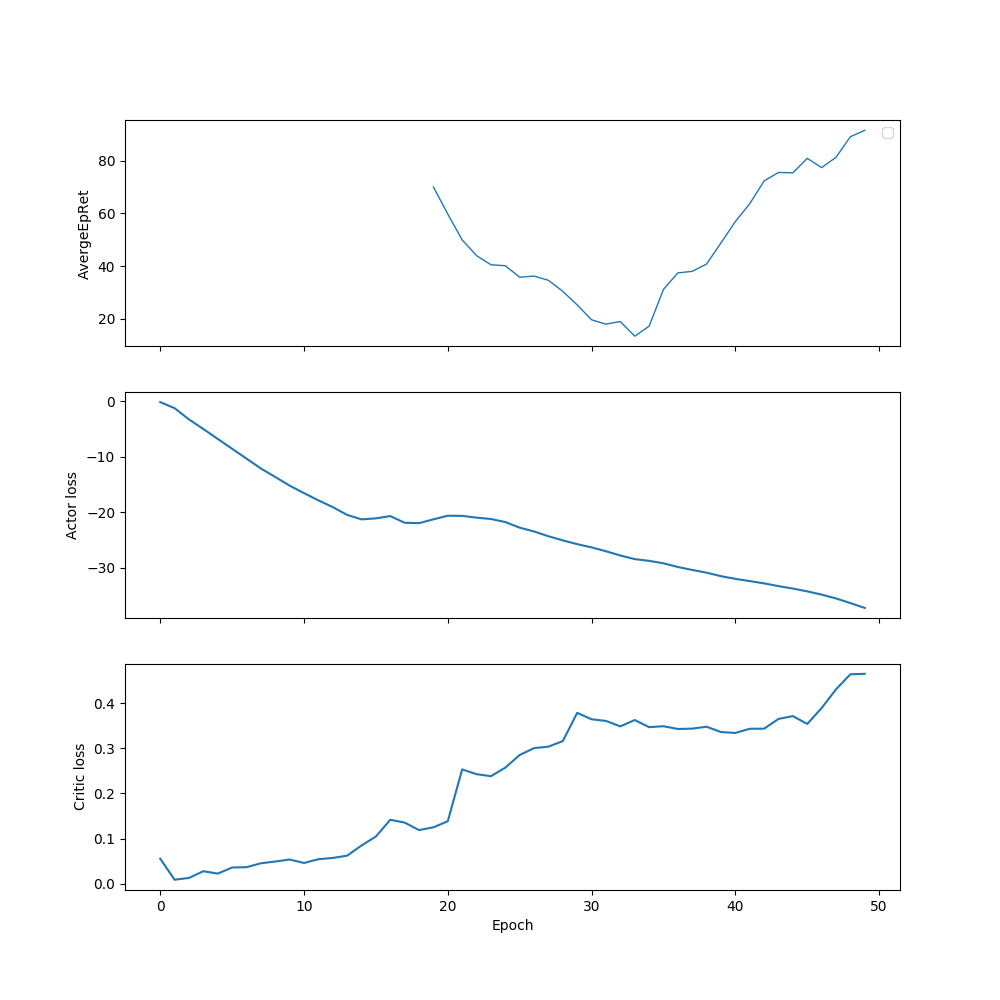

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


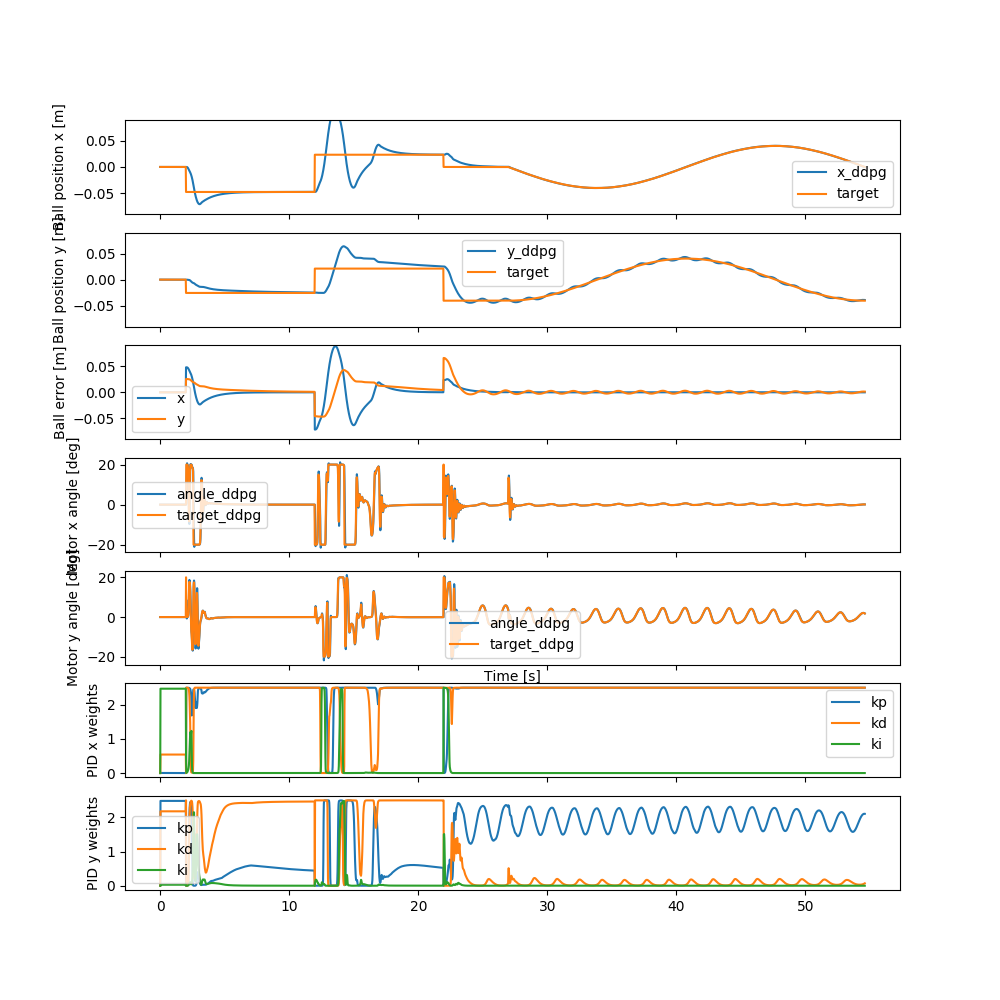

In [9]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='angle_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='angle_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [10]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.13217775821685793, 0.0007221597194671631, 0.0008730570785701275]}
{'weights': [0.13217775821685793, 0.0007221597194671631, 0.0008730570785701275]}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03576594,  0.00884026], dtype=float32), array([-0.01158725,  0.00824958], dtype=float32), array([ 0.00098398, -0.00017918], dtype=float32))
-0.0009616747966625422


<IPython.core.display.Javascript object>


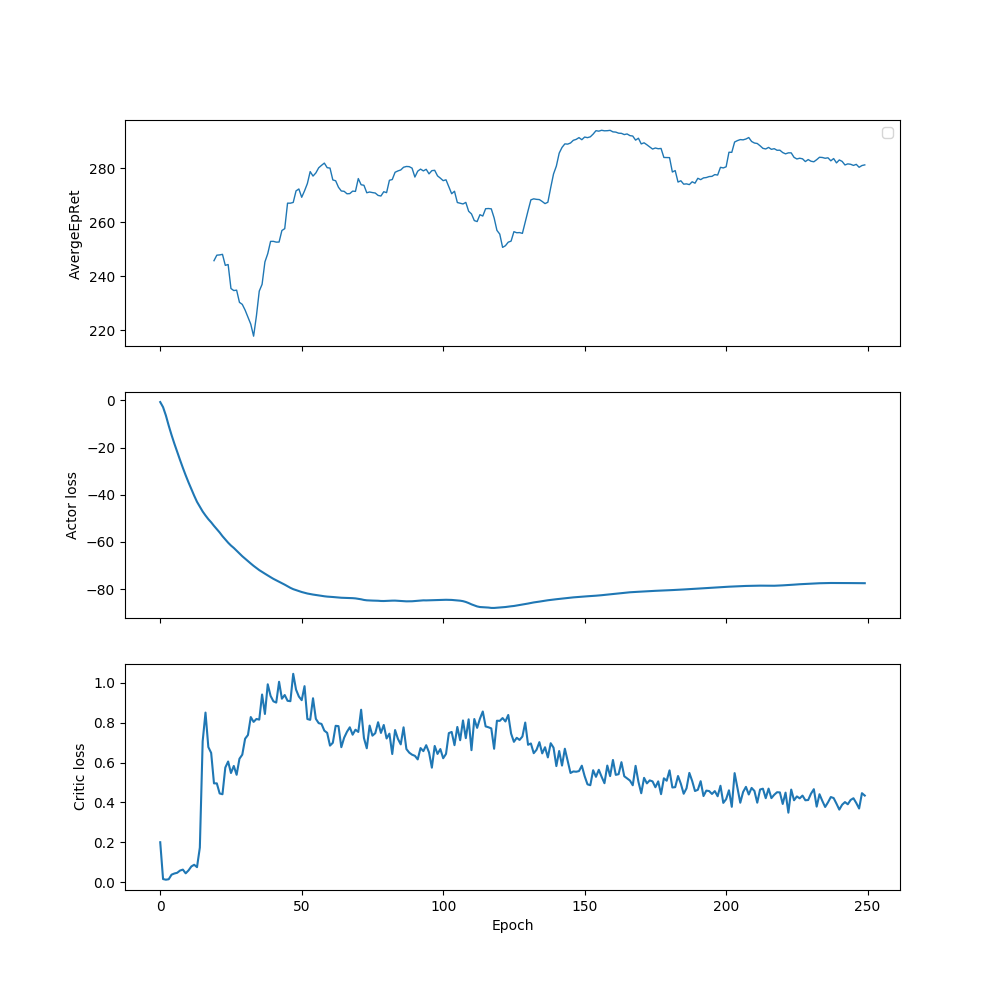

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


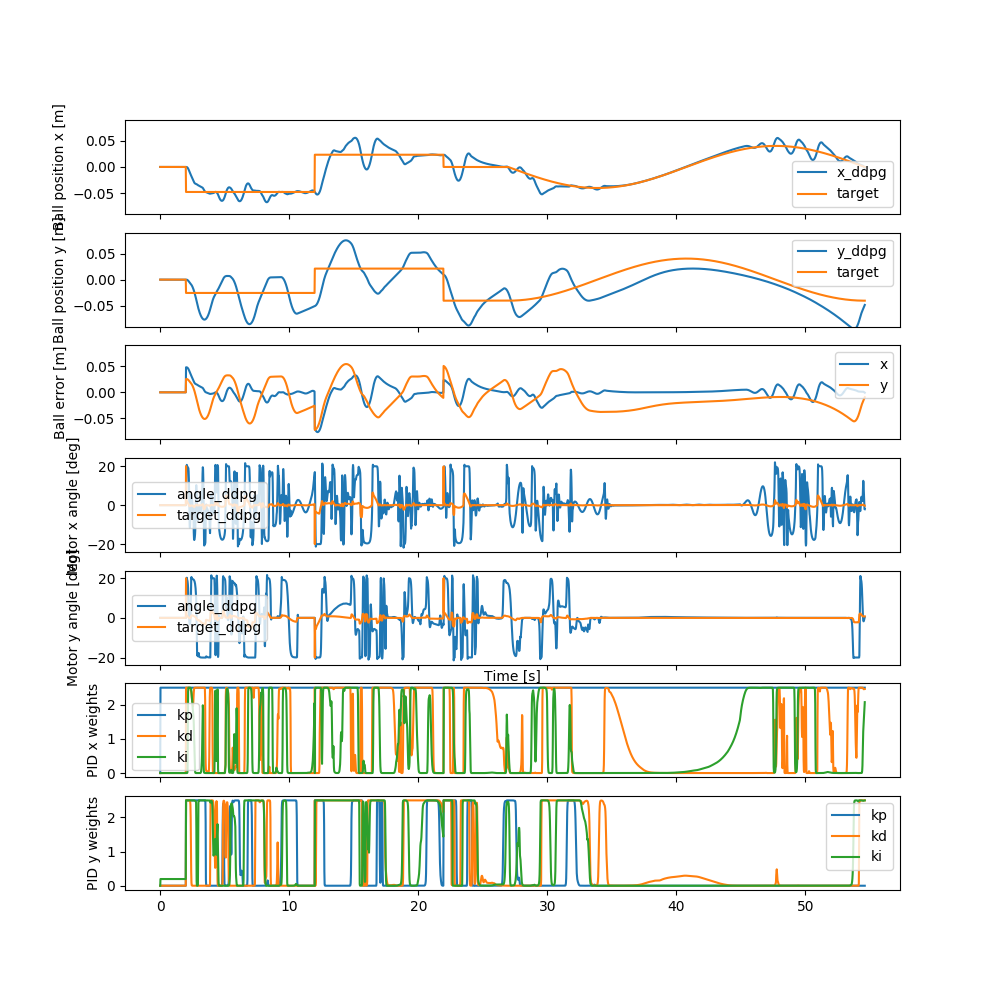

In [11]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='angle_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='angle_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [12]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.13217775821685793, 7.22159719467163e-05, 0.0008730570785701275]}
{'weights': [0.13217775821685793, 7.22159719467163e-05, 0.0008730570785701275]}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.07091215, 0.0351637 ], dtype=float32), array([0.05031028, 0.05614348], dtype=float32), array([ 0.00031273, -0.00281808], dtype=float32))
-0.0003193927234363338


<IPython.core.display.Javascript object>


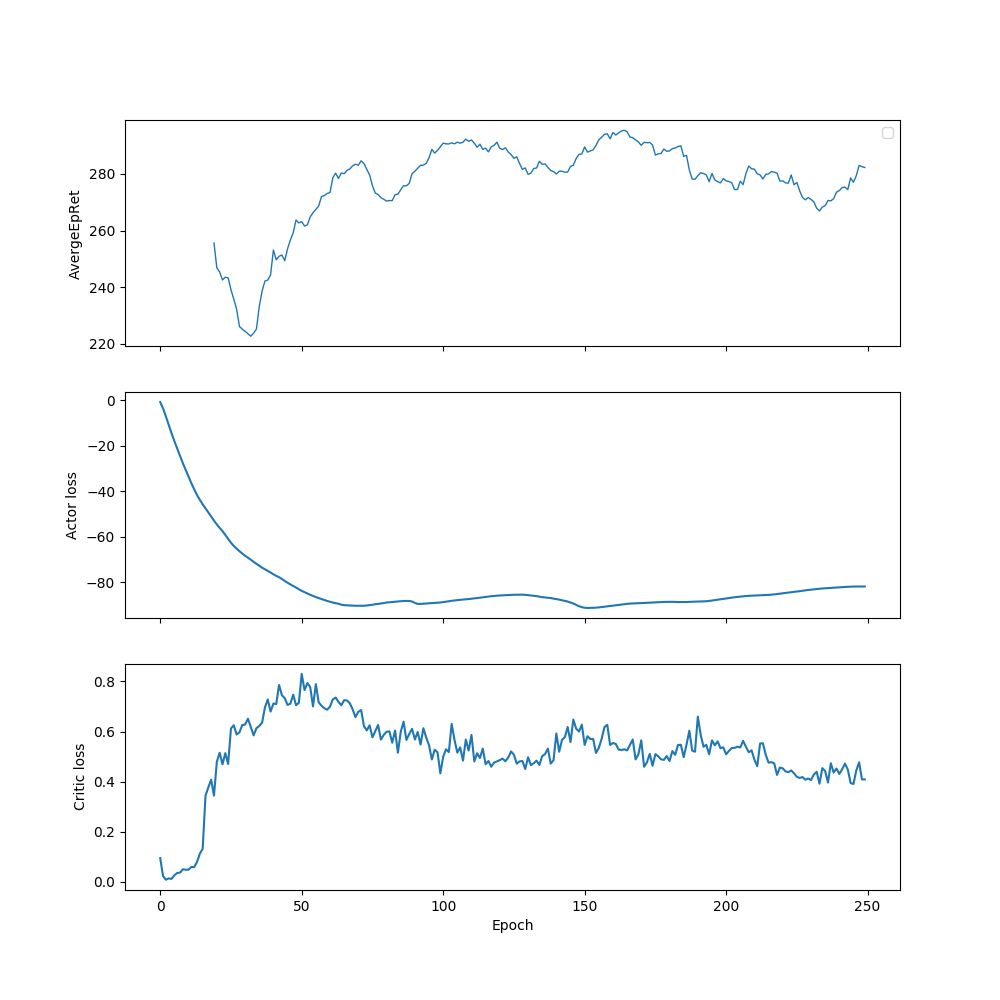

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


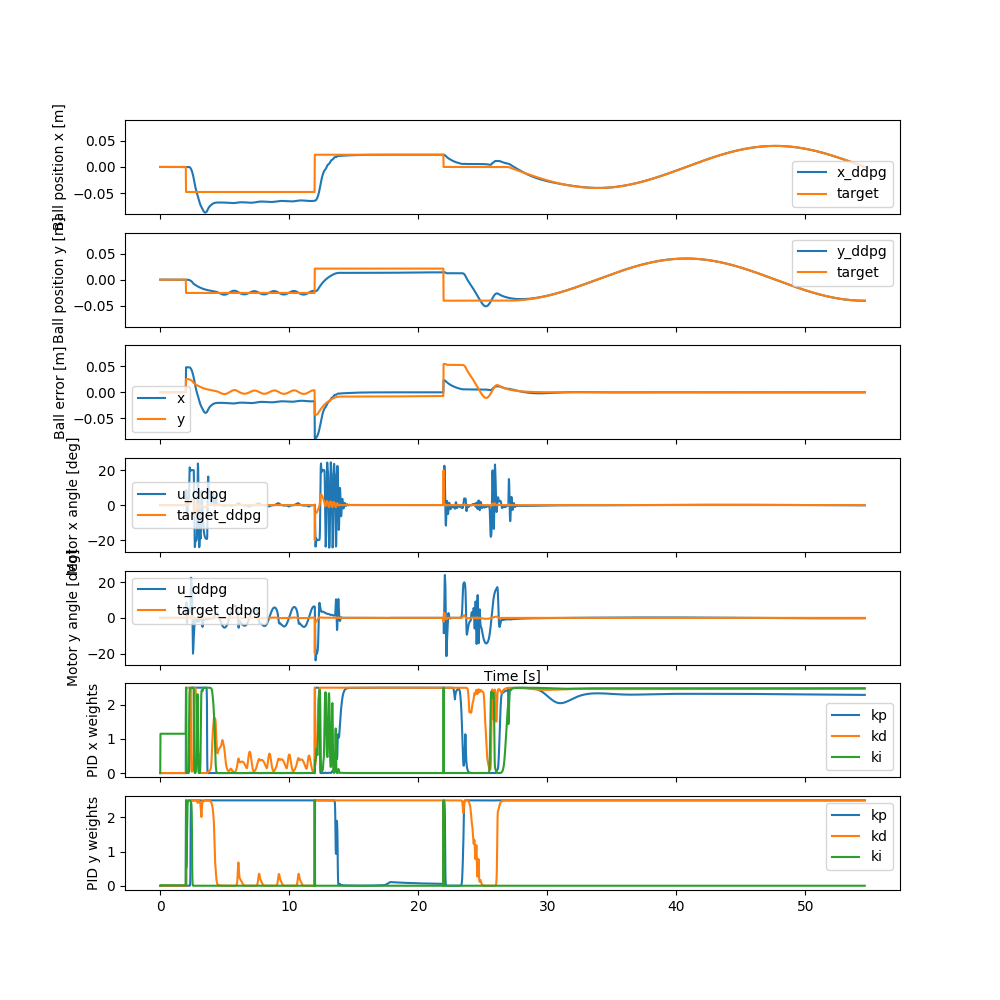

In [13]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [14]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03976269, 0.02569852], dtype=float32), array([0.03132093, 0.06790242], dtype=float32), array([-0.00070014, -0.00183208], dtype=float32))
-0.0002761254530044412


<IPython.core.display.Javascript object>


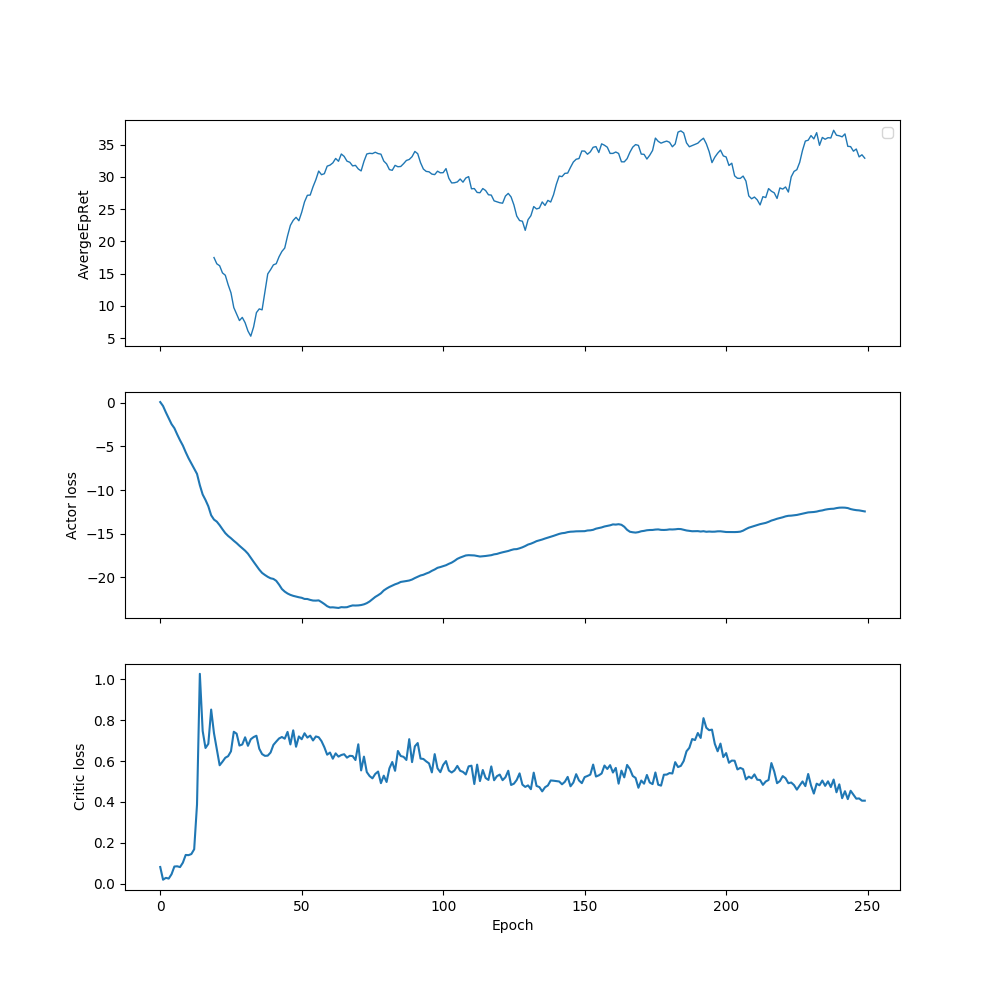

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


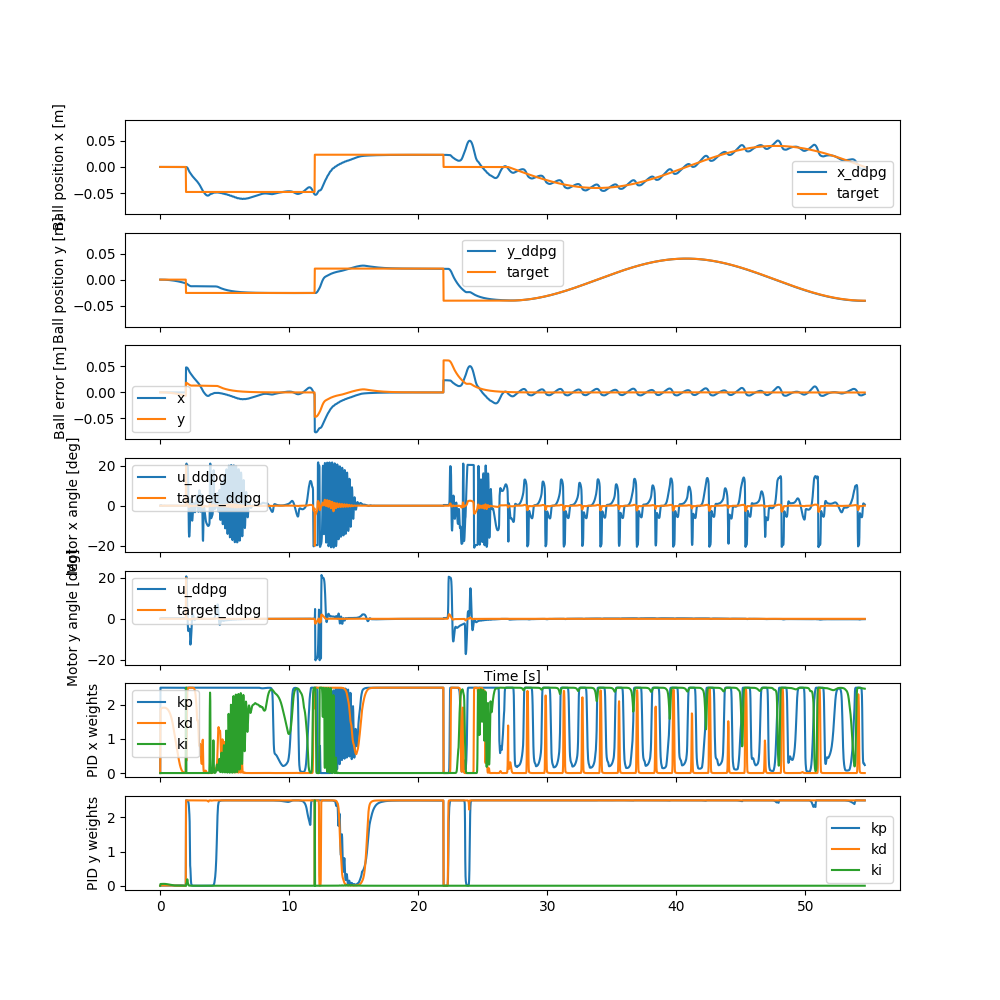

In [15]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [16]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='le0.3_[100]_signmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01440338, -0.04288448], dtype=float32), array([-0.06754411, -0.03757646], dtype=float32), array([-0.00060089,  0.00236753], dtype=float32))
-0.00017439852040807886


<IPython.core.display.Javascript object>


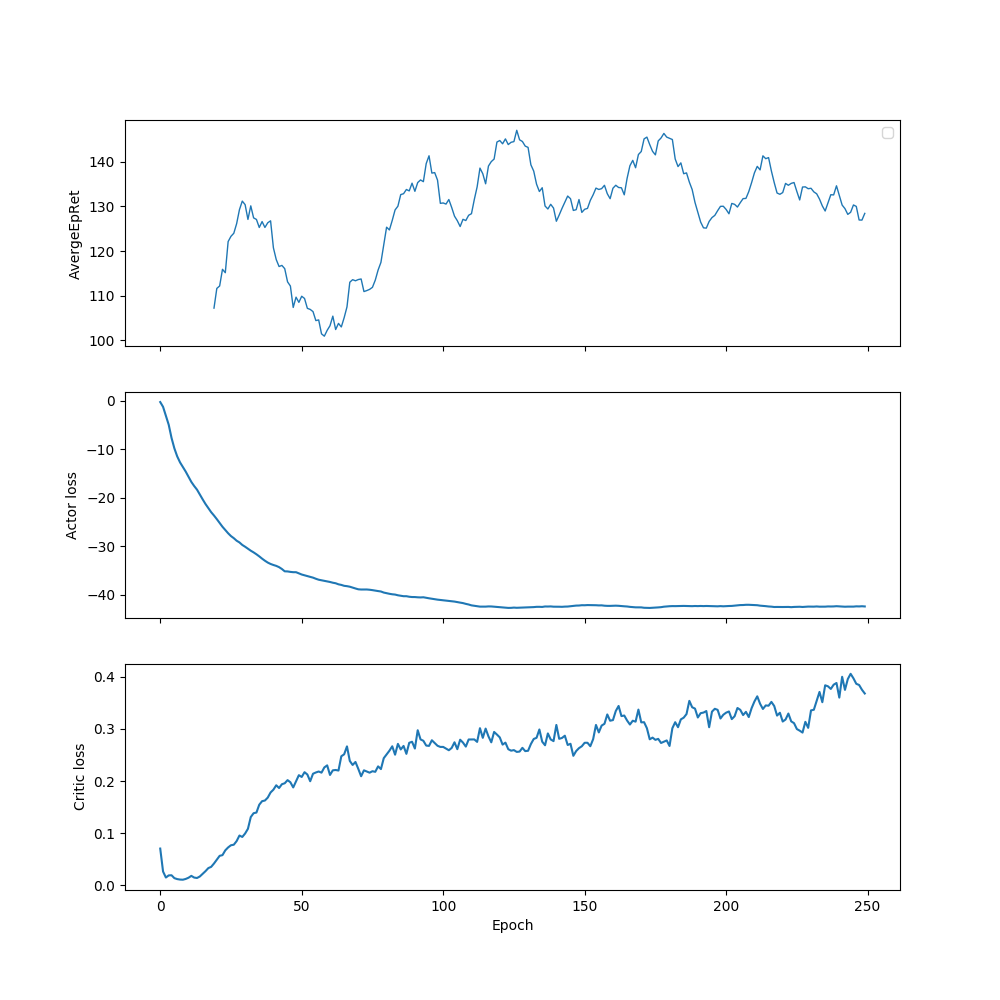

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


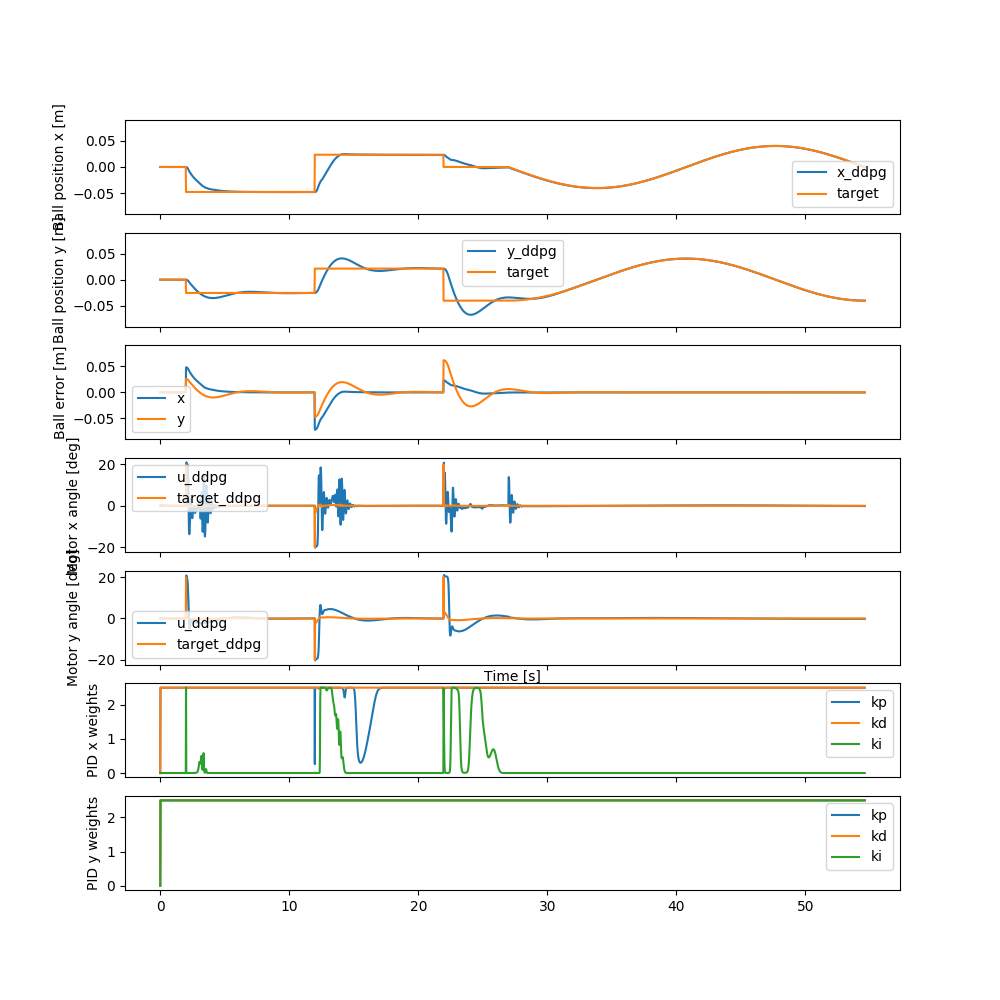

In [17]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [18]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pe1_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04916554,  0.00295098], dtype=float32), array([-0.03610279,  0.05546499], dtype=float32), array([-0.00108772, -0.0006153 ], dtype=float32))
-0.0005294222133068575


<IPython.core.display.Javascript object>


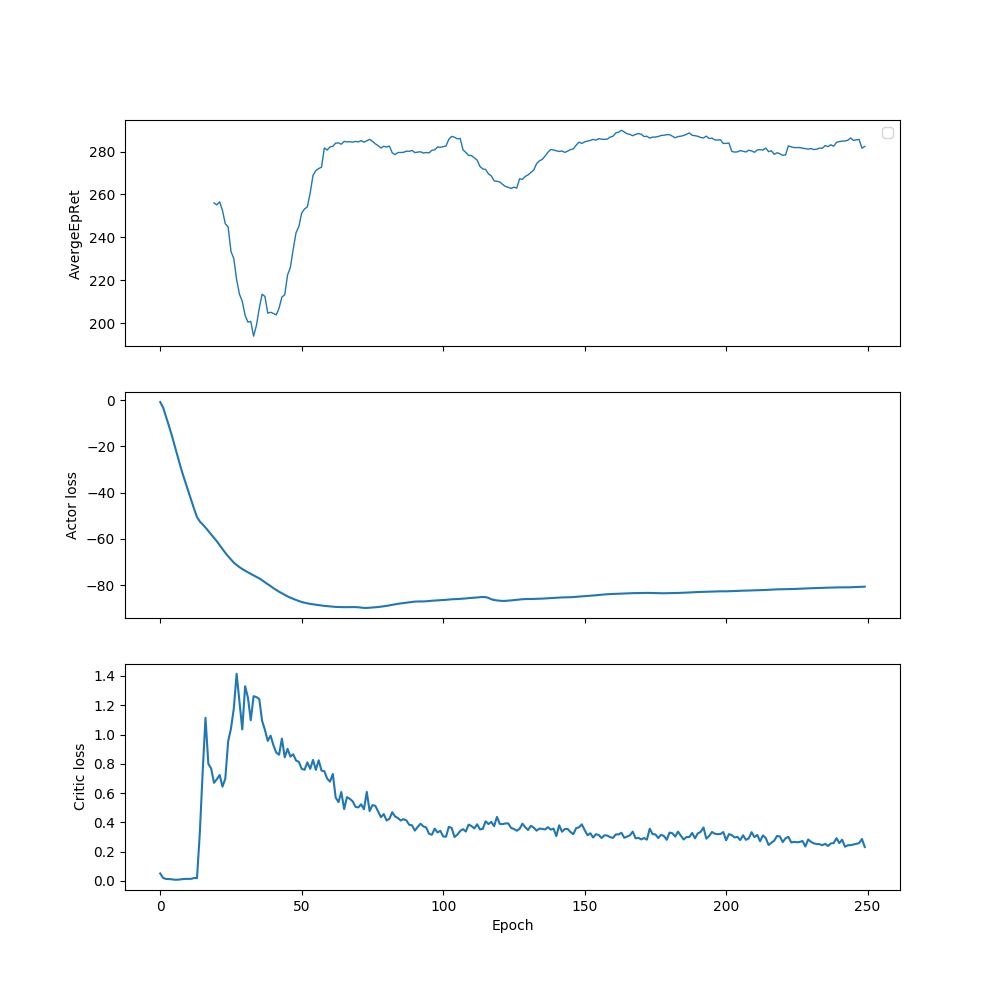

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


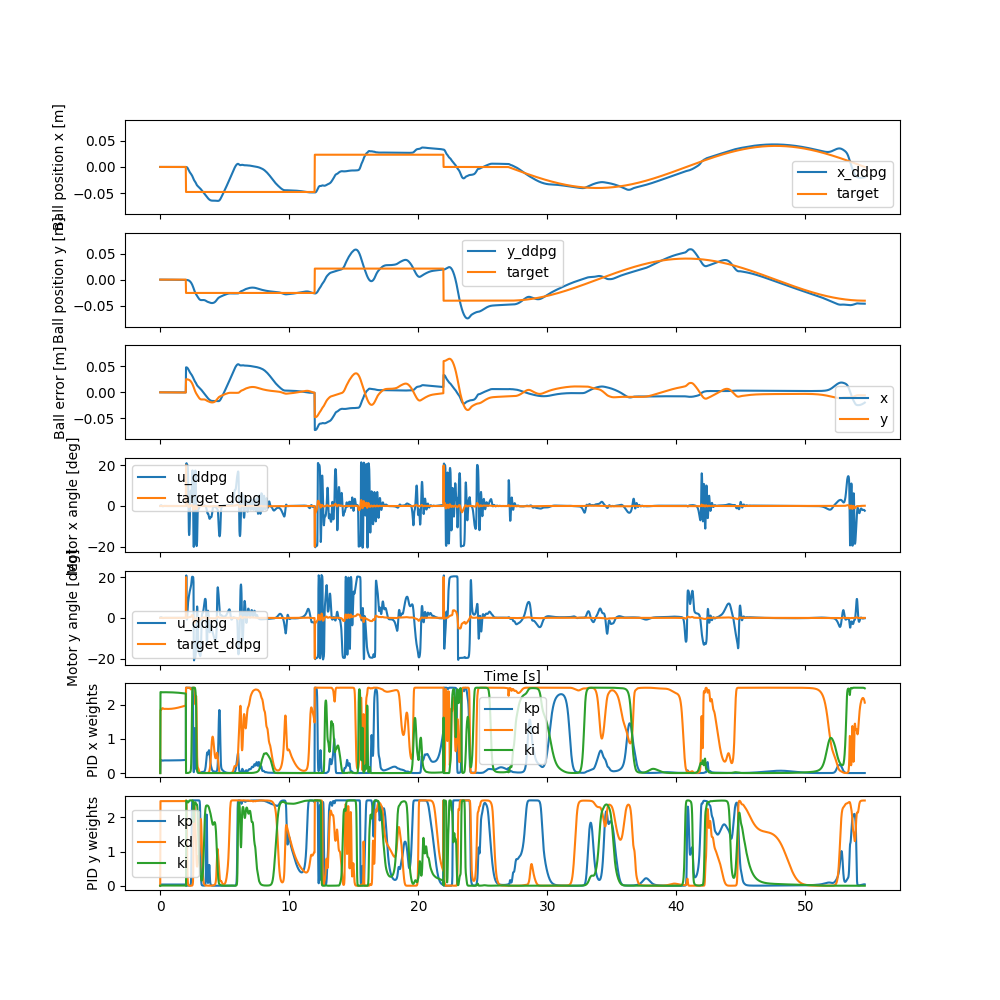

In [19]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [20]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pep0.3_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00272169,  0.0617872 ], dtype=float32), array([-0.04574576,  0.0454834 ], dtype=float32), array([-0.00177833, -0.00073108], dtype=float32))
-0.0003065503006589296


<IPython.core.display.Javascript object>


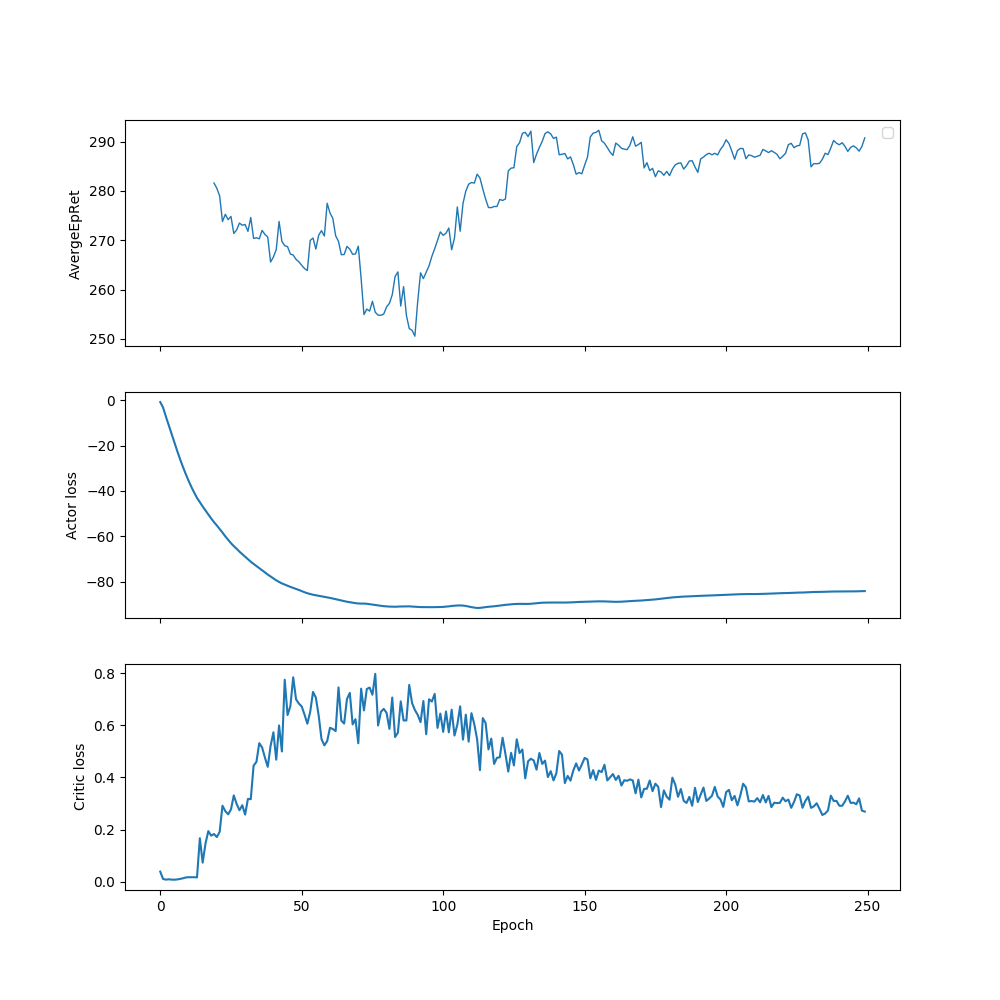

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


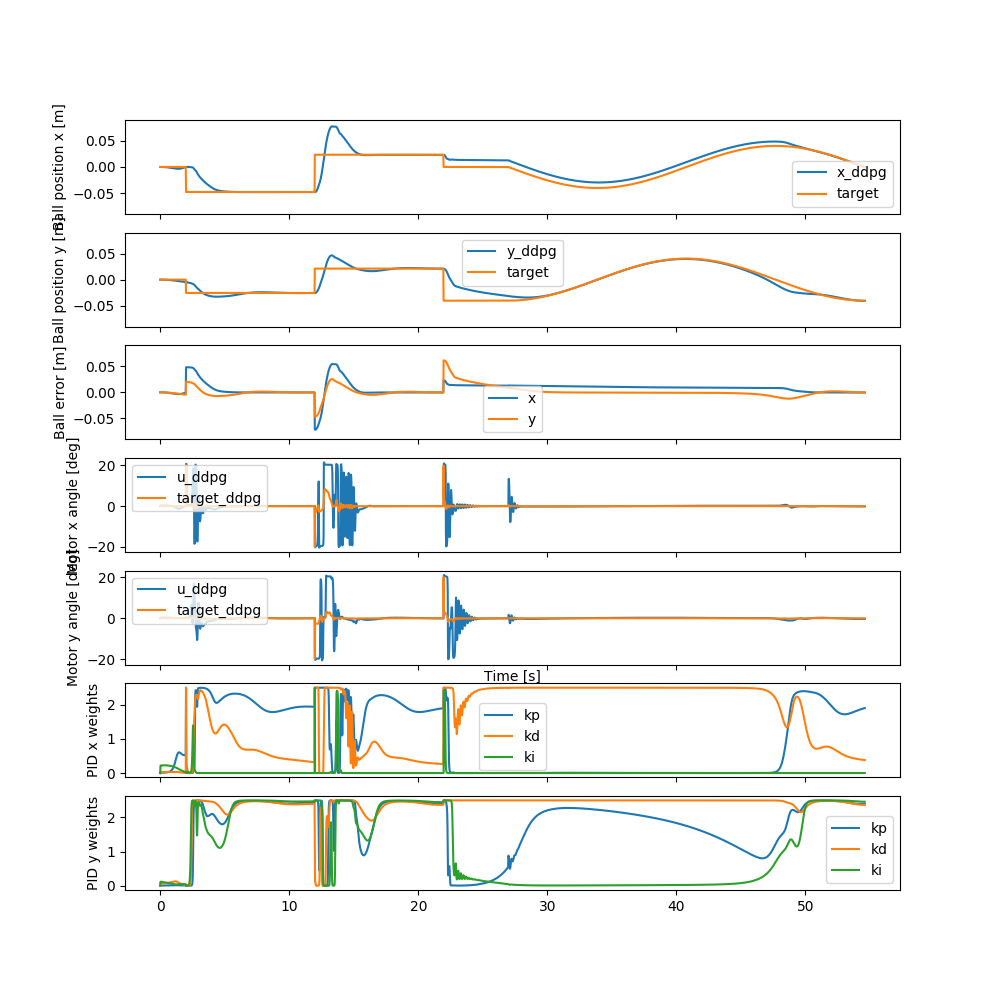

In [21]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [22]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.0688265 , -0.06032506], dtype=float32), array([0.0054967 , 0.00604183], dtype=float32), array([0.00224786, 0.00083514], dtype=float32))
-0.00042601971179265154


<IPython.core.display.Javascript object>


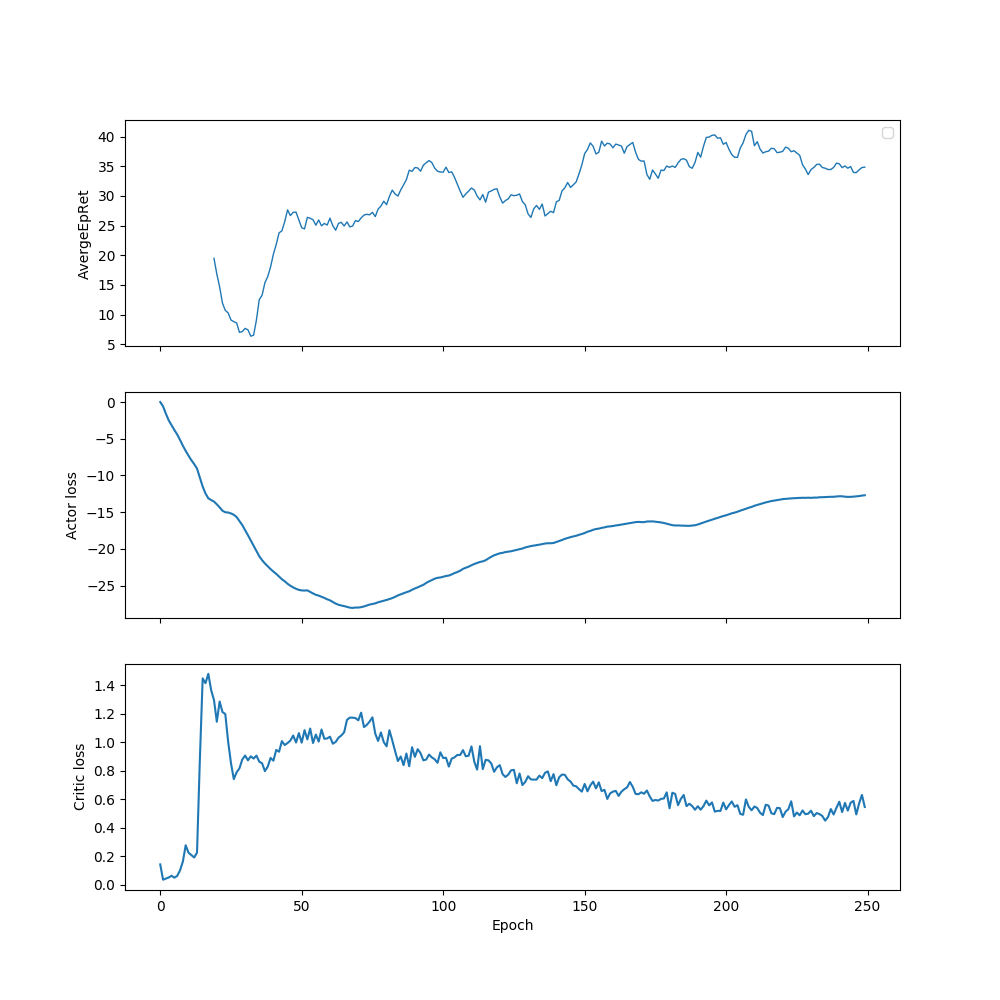

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


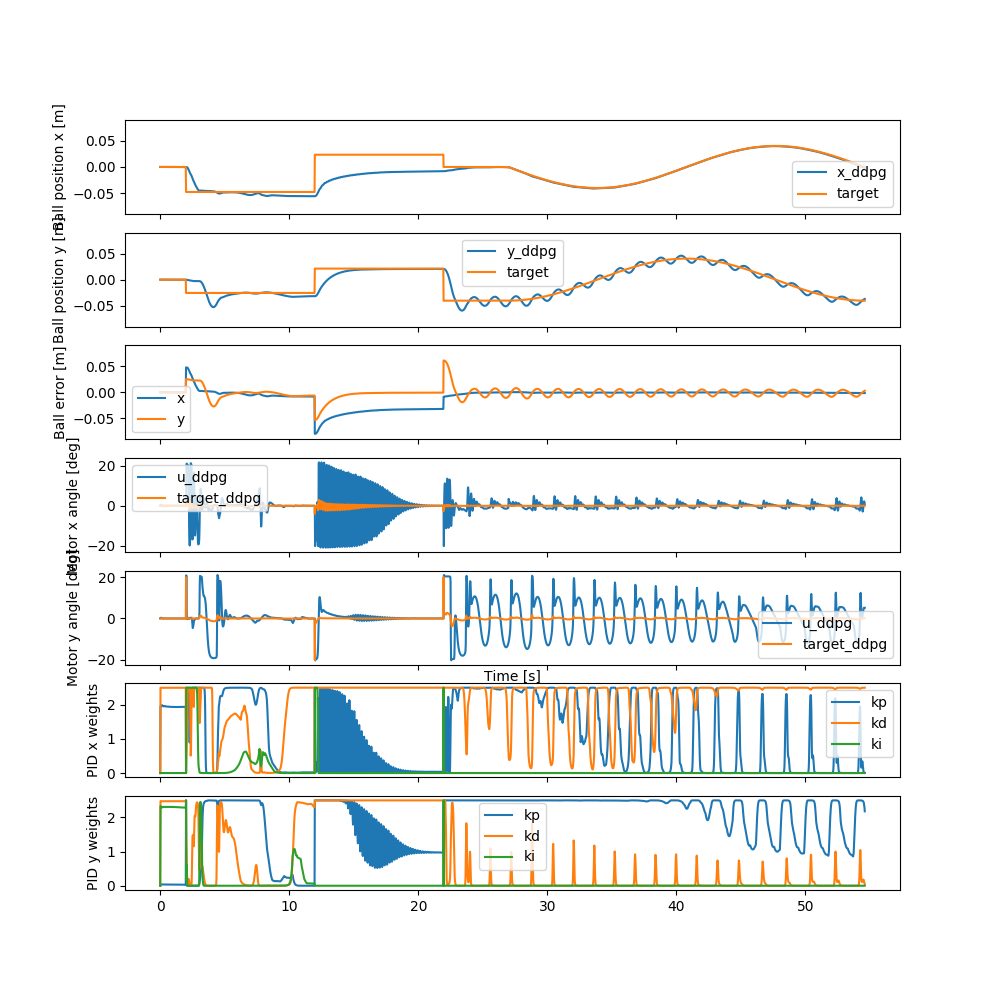

In [23]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [24]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05002148,  0.05273046], dtype=float32), array([-0.0406729 ,  0.03310318], dtype=float32), array([-0.00045221,  0.00225033], dtype=float32))
-0.00023805905931821556


<IPython.core.display.Javascript object>


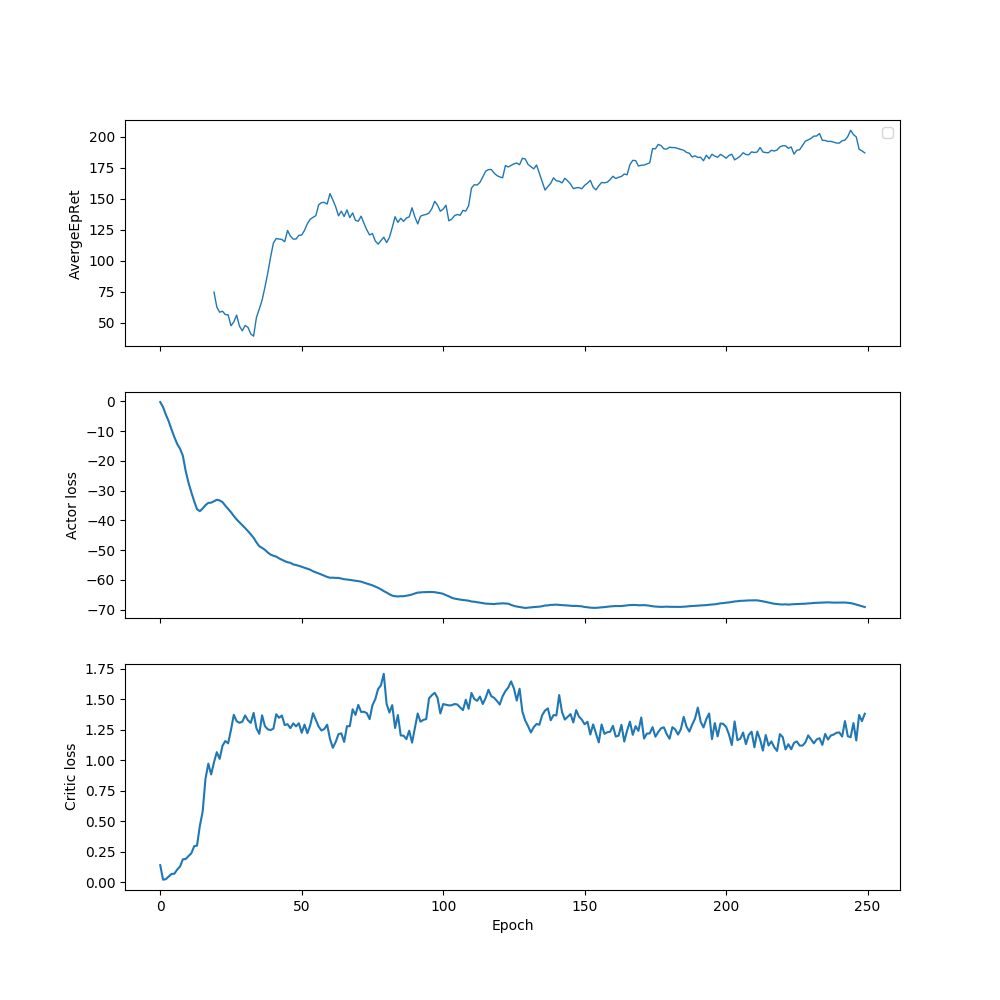

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


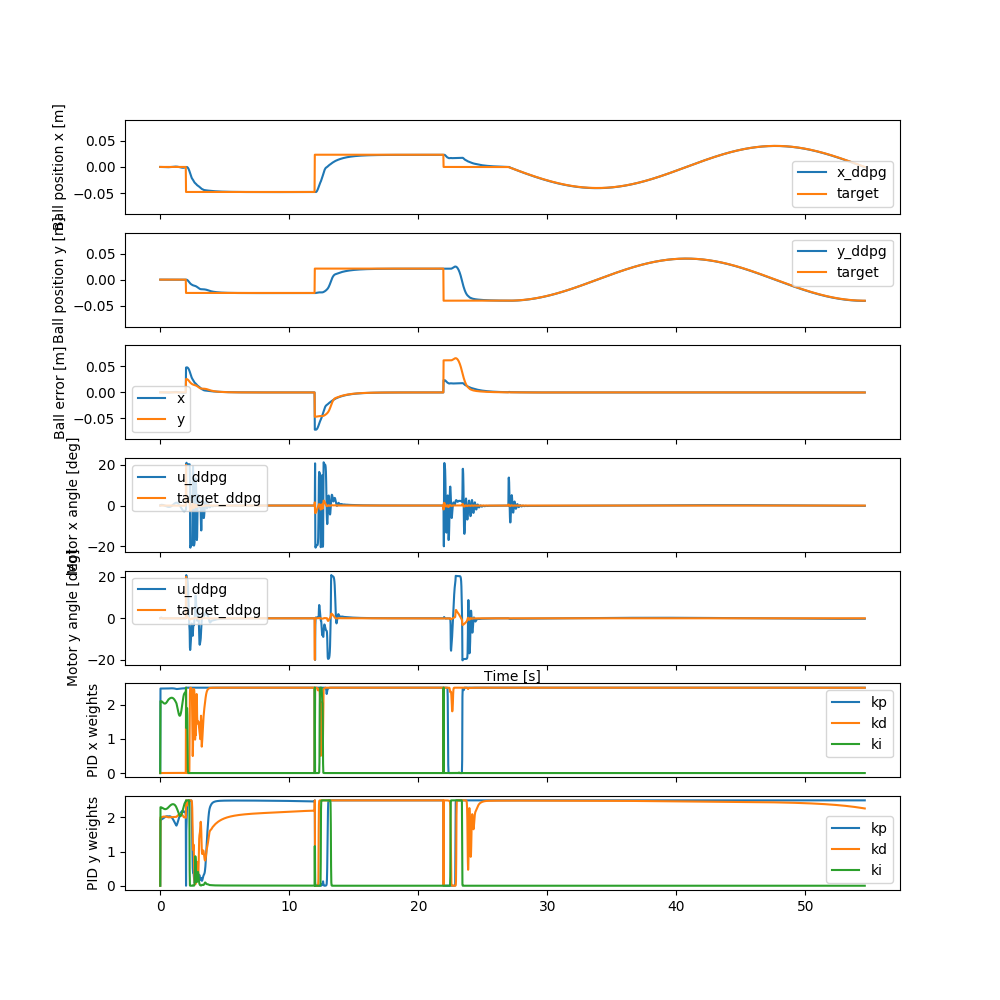

In [25]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [26]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1.4
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1.4_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.01475604, -0.06754331], dtype=float32), array([0.00284539, 0.06800686], dtype=float32), array([ 0.0026719 , -0.00293599], dtype=float32))
-0.0006464198825673161


<IPython.core.display.Javascript object>


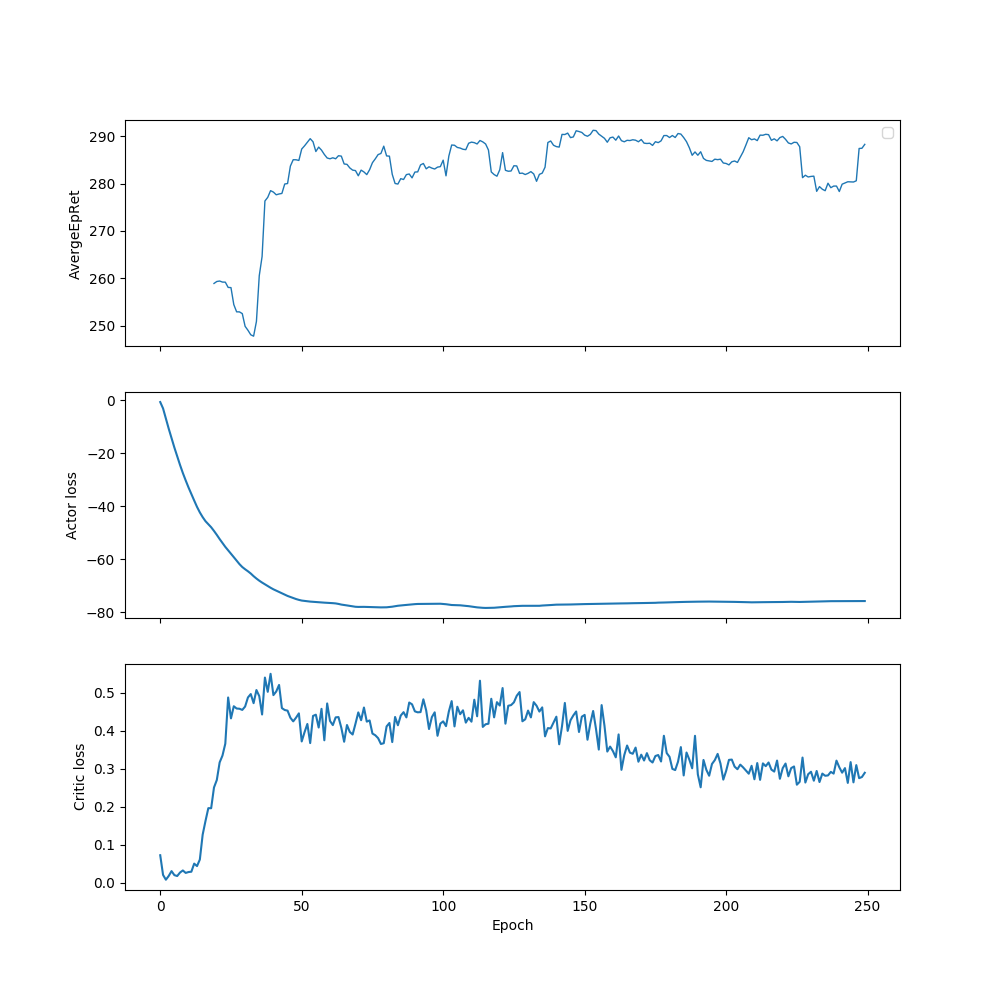

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


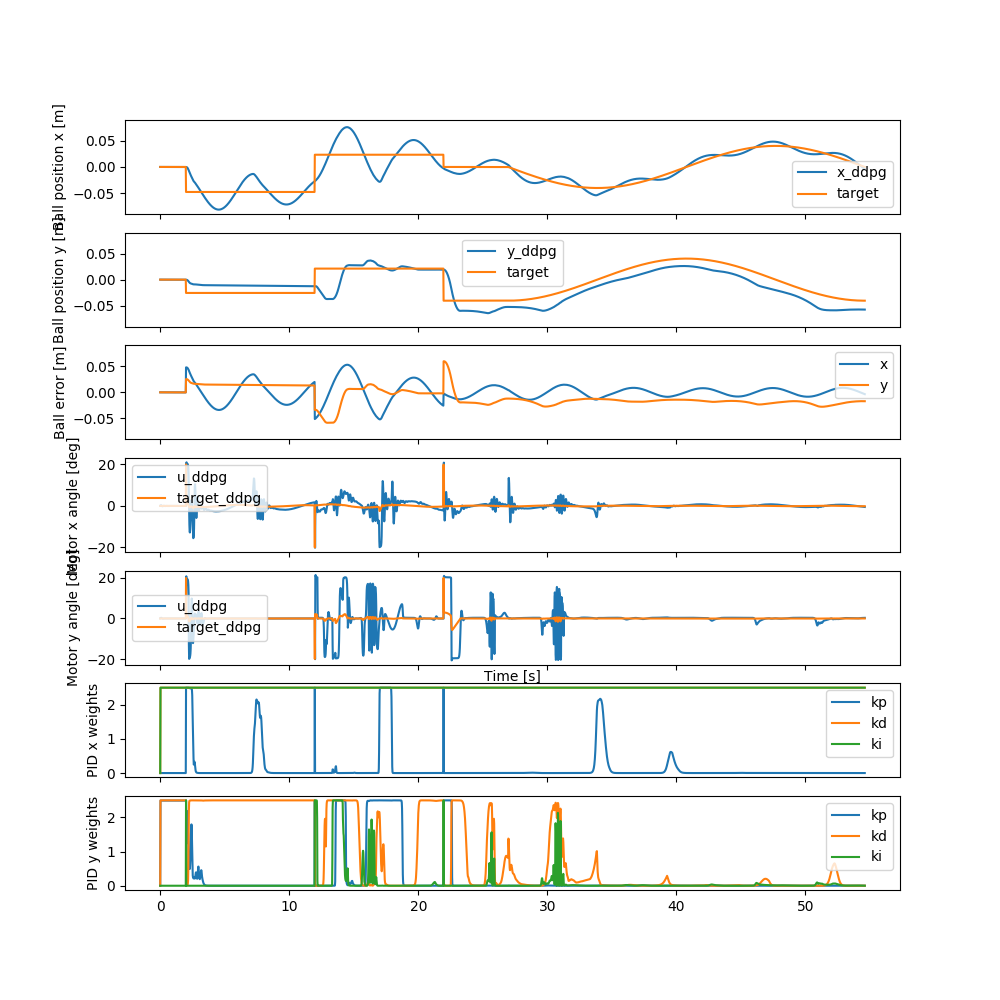

In [27]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [28]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03688462,  0.03069237], dtype=float32), array([-0.03813032, -0.00121703], dtype=float32), array([-0.00081046, -0.00036511], dtype=float32))
-0.0004583953384015481


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


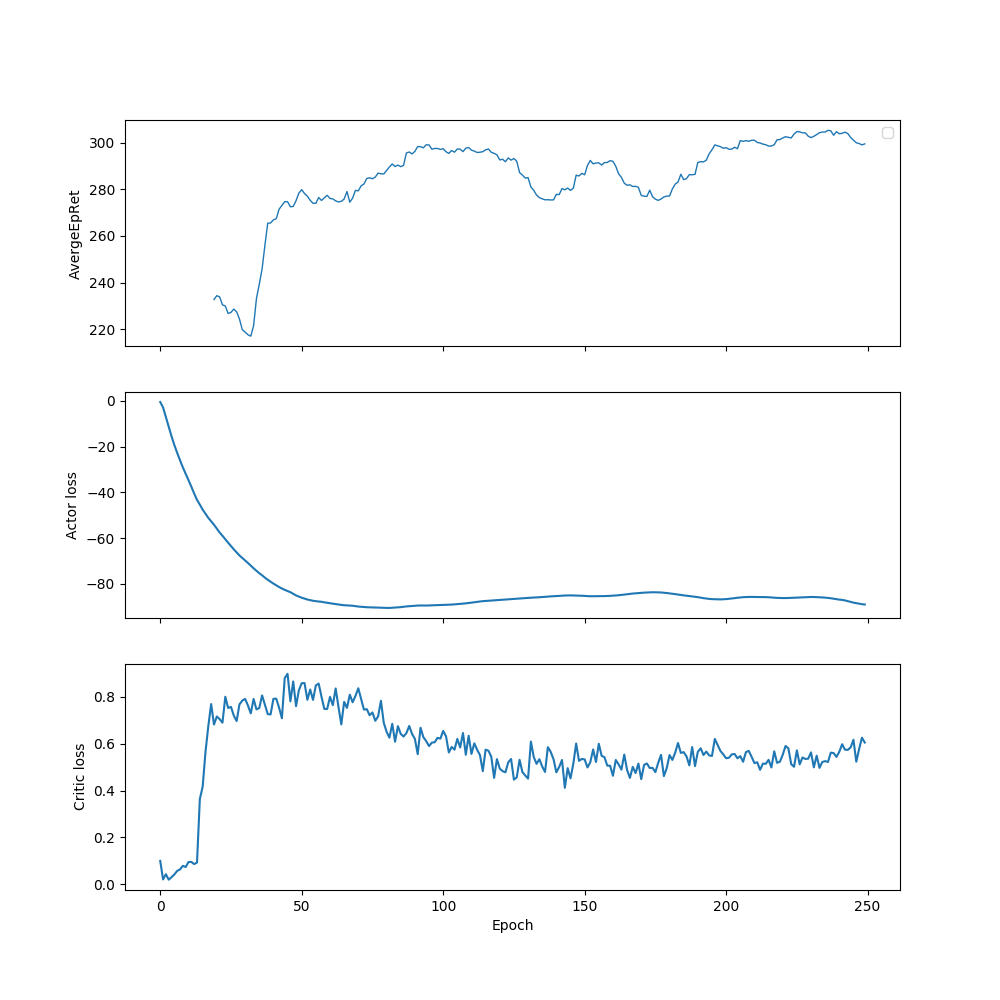

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


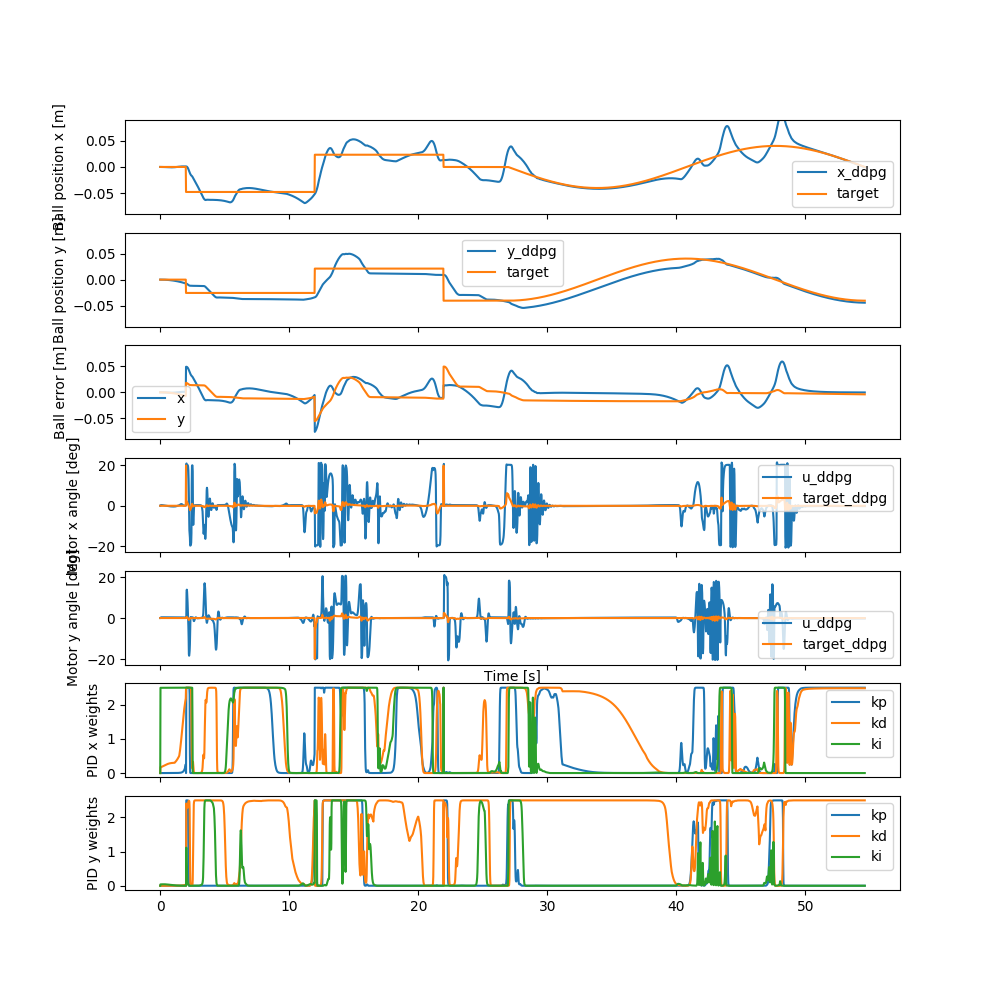

In [29]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [30]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 5
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de5_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.0], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01879304, -0.0491808 ], dtype=float32), array([-0.05329297, -0.04552598], dtype=float32), array([0.00184978, 0.00243089], dtype=float32))
-0.0002535879219504248


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


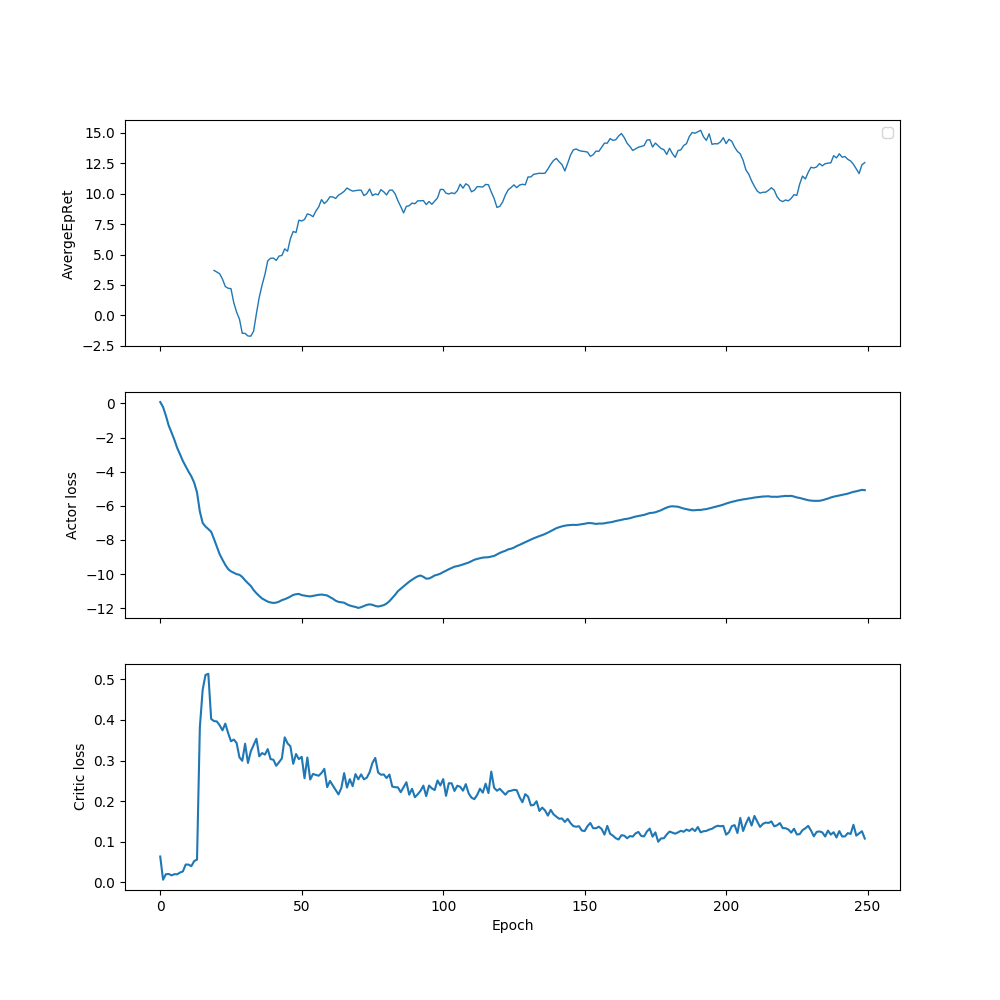

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


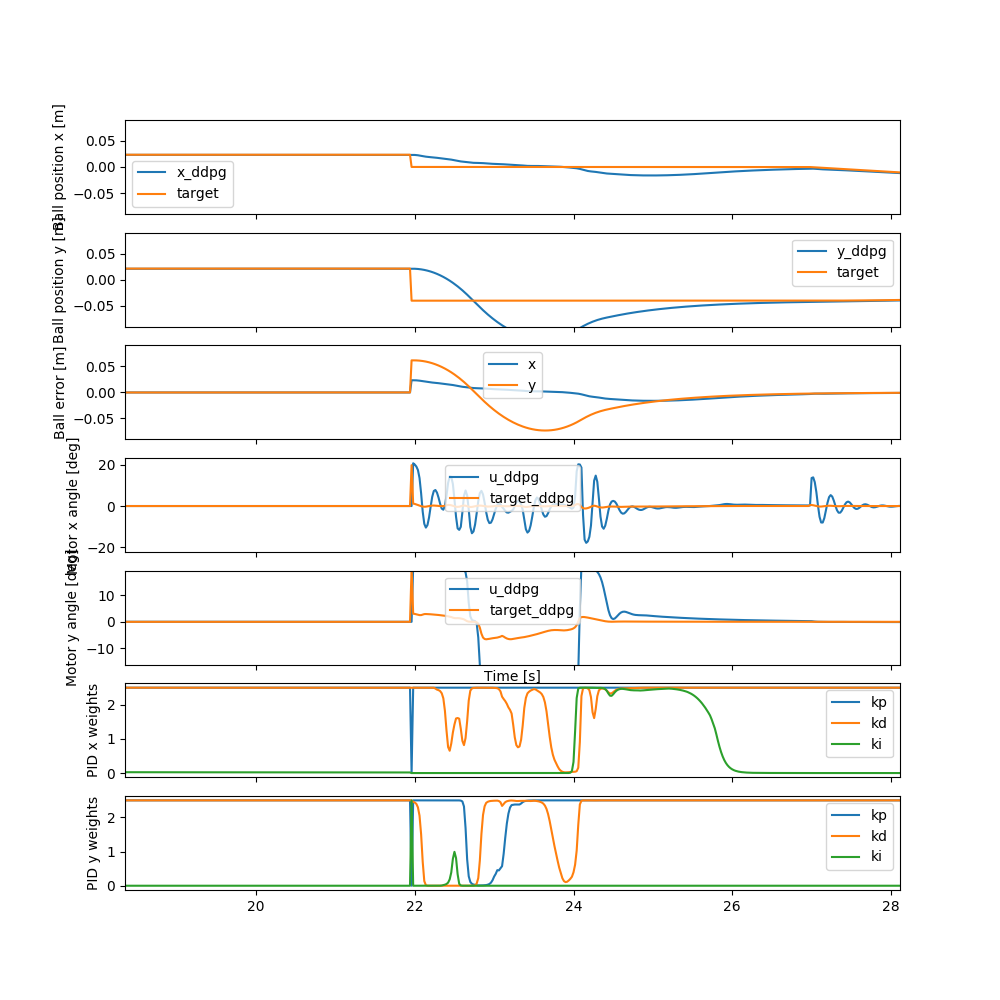

In [31]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()